## Plan for acquire:

1. Pull most forked repos. There are over 4 million forked repos, so we can easily get as many repos as we need. 

In [1]:
import numpy as np
import pandas as pd

# acquire
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import os

# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# model
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Space for importing acquire/prep functions that I've saved.

# Acquire

In [ ]:
# First off, going to try and grab the html from a single repo; then I'll try and go it for a full page of results.

In [ ]:
def make_soup(url):
    '''
    This helper function takes in a url and requests and parses HTML
    returning a soup object.
    '''
    headers = {'User-Agent': 'Sir Galahad'} 
    response = get(url, headers=headers)    
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [ ]:
def get_language_urls():
    '''
    This function scrapes all of the Codeup blog urls from
    the main Codeup blog page and returns a list of urls.
    '''
    
    urls = []
    
    languages = ['JavaScript', 'Python']
    
    for language in languages:
        for i in range(1,40):
            # first page for most starred repos on GH
            url = f'https://github.com/search?l={language}&p={i}&q=stars%3A%3E0&s=stars&type=Repositories'

            urls.append(url)
    return urls

In [ ]:
def get_single_language_urls(lang_choice):
    '''
    This function scrapes all of the Codeup blog urls from
    the main Codeup blog page and returns a list of urls.
    '''
    
    urls = []
    
    languages = [f'{lang_choice}']
    
    for language in languages:
        for i in range(1,40):
            # first page for most starred repos on GH
            url = f'https://github.com/search?l={language}&p={i}&q=stars%3A%3E0&s=stars&type=Repositories'

            urls.append(url)
    return urls

In [ ]:
def get_all_urls(urls):
    '''
    This function scrapes all of the urls from
    the list of github search result urls and returns a list of urls.
    '''
    
    repo_urls = []
    n = 0
    for url in urls:
        # Make request and soup object using helper
        soup = make_soup(url)
        sleep(3)
        n = n + 1
        print(f"Scraping loop number {n}")
        # Create a list of the anchor elements that hold the urls.
        urls_list = soup.find_all('a', class_='v-align-middle')
    
        # I'm using a set comprehension to return only unique urls.
        urls_set = {'https://github.com' + link.get('href') for link in urls_list}
        urls_set = list(urls_set)
        repo_urls.extend(urls_set)

    # I'm converting my set to a list of urls.
    # urls = list(urls) 
        
    return repo_urls

### The Plan:

Run through this function process twice; once for the javascript and python. That *should* give us two separate lists of individual repo urls that are 180 urls long each; then we can concat those two lists into a complete list of 360 unique repo urls (theoretically).

In [ ]:
# Getting Javascript search results:

js_urls = get_single_language_urls('JavaScript')
len(js_urls)

In [ ]:
# Now getting the individual repo urls from the above javascript search results:

js_repos = get_all_urls(js_urls)
len(js_repos)

In [ ]:
js_repos

In [ ]:
# Now doing the python repo list:

py_urls = get_single_language_urls('Python')
len(py_urls)

In [ ]:
# Now getting the individual repo urls from the above javascript search results:

py_repos = get_all_urls(py_urls)
len(py_repos)

In [ ]:
py_repos

In [ ]:
# Joining the two lists together...

joined_repos = py_repos + js_repos

In [ ]:
len(joined_repos)

In [ ]:
joined_repos

In [ ]:
import github_acquire

In [ ]:
new_list = []

for item in joined_repos:
    new_list.append(item[19:])

In [ ]:
new_list

In [ ]:
count_len = joined_repos[0]

In [ ]:
count_len[19:]

In [ ]:
"""
A module for obtaining repo readme and language data from the github API.
Before using this module, read through it, and follow the instructions marked
TODO.
After doing so, run it like this:
    python acquire.py
To create the `data.json` file that contains the data.
"""
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username

# TODO: Make a github personal access token.
#     1. Go here and generate a personal access token https://github.com/settings/tokens
#        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
#     2. Save it in your env.py file under the variable `github_token`
# TODO: Add your github username to your env.py file under the variable `github_username`
# TODO: Add more repositories to the `REPOS` list below.

REPOS = new_list

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        return repo_info.get("language", None)
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = None
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]


if __name__ == "__main__":
    data = scrape_github_data()
    json.dump(data, open("data.json", "w"), indent=1)

In [2]:
df = pd.read_json('data.json')

In [3]:
df.head()

,repo,language,readme_contents
0,ytdl-org/youtube-dl,Python,[![Build Status](https://travis-ci.org/ytdl-or...
1,jackfrued/Python-100-Days,Python,## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...
2,pallets/flask,Python,Flask\n=====\n\nFlask is a lightweight `WSGI`_...
3,django/django,Python,======\nDjango\n======\n\nDjango is a high-lev...
4,TheAlgorithms/Python,Python,# The Algorithms - Python\n[![Gitpod Ready-to-...


In [4]:
dups_list = df.repo.value_counts()[df.repo.value_counts() > 1].index.to_list()

In [5]:
df.language.value_counts(normalize = True)

JavaScript    0.560976
Python        0.439024
Name: language, dtype: float64

In [ ]:
# df shape before removing duplicates:

# Currently df w/dups is (410,3)

df.shape

### Removing duplicates from dataframe:

In [6]:
dups_list

['numpy/numpy',
 'VerbalExpressions/JSVerbalExpressions',
 'Automattic/wp-calypso',
 'greensock/GSAP',
 'tornadoweb/tornado',
 'iperov/DeepFaceLab',
 'gaearon/react-hot-loader',
 'ipython/ipython',
 'Semantic-Org/Semantic-UI-React',
 'pytorch/examples',
 'celery/celery',
 'charlax/professional-programming',
 'instillai/TensorFlow-Course',
 'donnemartin/interactive-coding-challenges',
 'binux/pyspider',
 'deezer/spleeter',
 'phobal/ivideo',
 'gpujs/gpu.js',
 'mitmproxy/mitmproxy',
 'pypa/pipenv',
 'donnemartin/data-science-ipython-notebooks',
 'http-party/node-http-proxy',
 'krisk/Fuse',
 'alpinejs/alpine',
 'magenta/magenta']

In [7]:
len(df[df.repo.isin(dups_list)])

50

In [8]:
df_test = df.copy()

In [9]:
df_test.shape

(410, 3)

In [10]:
df_test.drop_duplicates(subset = 'repo', ignore_index = True, inplace = True)

In [11]:
df_test.shape

(385, 3)

In [12]:
df_test.language.value_counts(normalize = True)

JavaScript    0.571429
Python        0.428571
Name: language, dtype: float64

In [13]:
df_test.readme_contents

0      [![Build Status](https://travis-ci.org/ytdl-or...
1      ## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...
2      Flask\n=====\n\nFlask is a lightweight `WSGI`_...
3      ======\nDjango\n======\n\nDjango is a high-lev...
4      # The Algorithms - Python\n[![Gitpod Ready-to-...
                             ...                        
380    # Yup\n\nYup is a JavaScript schema builder fo...
381    # ![NodeBB](public/images/logo.svg)\n\n[![Buil...
382    # ShellJS - Unix shell commands for Node.js\n\...
383    <p>\n  <a href="https://aurelia.io/" target="_...
384    <p align="center"><img width='270px' src="http...
Name: readme_contents, Length: 385, dtype: object

In [14]:
df_test.head()

,repo,language,readme_contents
0,ytdl-org/youtube-dl,Python,[![Build Status](https://travis-ci.org/ytdl-or...
1,jackfrued/Python-100-Days,Python,## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...
2,pallets/flask,Python,Flask\n=====\n\nFlask is a lightweight `WSGI`_...
3,django/django,Python,======\nDjango\n======\n\nDjango is a high-lev...
4,TheAlgorithms/Python,Python,# The Algorithms - Python\n[![Gitpod Ready-to-...


In [15]:
df_test.readme_contents[0]

'[![Build Status](https://travis-ci.org/ytdl-org/youtube-dl.svg?branch=master)](https://travis-ci.org/ytdl-org/youtube-dl)\n\nyoutube-dl - download videos from youtube.com or other video platforms\n\n- [INSTALLATION](#installation)\n- [DESCRIPTION](#description)\n- [OPTIONS](#options)\n- [CONFIGURATION](#configuration)\n- [OUTPUT TEMPLATE](#output-template)\n- [FORMAT SELECTION](#format-selection)\n- [VIDEO SELECTION](#video-selection)\n- [FAQ](#faq)\n- [DEVELOPER INSTRUCTIONS](#developer-instructions)\n- [EMBEDDING YOUTUBE-DL](#embedding-youtube-dl)\n- [BUGS](#bugs)\n- [COPYRIGHT](#copyright)\n\n# INSTALLATION\n\nTo install it right away for all UNIX users (Linux, macOS, etc.), type:\n\n    sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl\n    sudo chmod a+rx /usr/local/bin/youtube-dl\n\nIf you do not have curl, you can alternatively use a recent wget:\n\n    sudo wget https://yt-dl.org/downloads/latest/youtube-dl -O /usr/local/bin/youtube-dl\n  

In [16]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [17]:
df_test.readme_contents[0]

'[![Build Status](https://travis-ci.org/ytdl-org/youtube-dl.svg?branch=master)](https://travis-ci.org/ytdl-org/youtube-dl)\n\nyoutube-dl - download videos from youtube.com or other video platforms\n\n- [INSTALLATION](#installation)\n- [DESCRIPTION](#description)\n- [OPTIONS](#options)\n- [CONFIGURATION](#configuration)\n- [OUTPUT TEMPLATE](#output-template)\n- [FORMAT SELECTION](#format-selection)\n- [VIDEO SELECTION](#video-selection)\n- [FAQ](#faq)\n- [DEVELOPER INSTRUCTIONS](#developer-instructions)\n- [EMBEDDING YOUTUBE-DL](#embedding-youtube-dl)\n- [BUGS](#bugs)\n- [COPYRIGHT](#copyright)\n\n# INSTALLATION\n\nTo install it right away for all UNIX users (Linux, macOS, etc.), type:\n\n    sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl\n    sudo chmod a+rx /usr/local/bin/youtube-dl\n\nIf you do not have curl, you can alternatively use a recent wget:\n\n    sudo wget https://yt-dl.org/downloads/latest/youtube-dl -O /usr/local/bin/youtube-dl\n  

In [33]:
# functions
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKC', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    string = re.sub(r'[\n]', "", string)
    string = re.sub(r'[/s./s]', " ", string)

    return string

In [34]:
df_test.readme_contents.apply(basic_clean)

0      build  tatu http travi ciorgytdlorgyoutubedl v...
1       python  100  8w15pythoncore50cour e http gith...
2      fla kfla k i  a lightweight w gi_ web applicat...
3      djangodjango i  a highlevel python web framewo...
4       the algorithm   pythongitpod readytocodehttp ...
                             ...                        
380     yupyup i  a java cript  chema builder for val...
381     nodebbpublicimage logo vgbuild  tatu http tra...
382      hellj   unix  hell command  for nodej travi ...
383    p  a hrefhttp aureliaio target_blank    img al...
384    p aligncenterimg width270px  rchttp githubcomr...
Name: readme_contents, Length: 385, dtype: object

In [36]:
short_df = pd.read_json('github_repos.json')

In [ ]:
# run some regex that'll replace \n with ""; \s.\s to get rid of all single charaters. Then run tokenize, lemmatize, and stopwords to come up with a clean column of text for explore.

In [37]:
short_df

,language,content
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and..."
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...
4,JavaScript,Create React App \n\nCreate React apps with n...
...,...,...
155,Java,Spring Boot Demo\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
156,Java,Selenium \n\nSelenium is an umbrella project ...
157,Java,Picasso\nA powerful image downloading and cach...
158,Java,EasyExcel\n\n\n\nQQ1群(已满): 662022184\nQQ2群: 10...


In [38]:
# functions
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKC', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

##############################

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

#############################

def stem(string):
    '''
    This function takes in a string and
    returns a string with words stemmed.
    '''
    # Create porter stemmer.
    ps = nltk.porter.PorterStemmer()
    
    # Use the stemmer to stem each word in the list of words we created by using split.
    stems = [ps.stem(word) for word in string.split()]
    
    # Join our lists of words into a string again and assign to a variable.
    string = ' '.join(stems)
    
    return string

#############################


def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

#############################


def remove_stopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)

    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

###############################


def prep_repo_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)\
                            .apply(lemmatize)
    
    df['stemmed'] = df[column].apply(basic_clean).apply(stem)
    
    df['lemmatized'] = df[column].apply(basic_clean).apply(lemmatize)
    
    return df[['language', column, 'stemmed', 'lemmatized', 'clean']]

In [39]:
clean_df = prep_repo_data(short_df, 'content')

In [40]:
clean_df.head()

,language,content,stemmed,lemmatized,clean
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",bootstrap sleek intuit and power frontend fram...,bootstrap sleek intuitive and powerful fronten...,bootstrap sleek intuitive powerful frontend fr...
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,support vuej vuej is an mitlicens open sourc p...,supporting vuejs vuejs is an mitlicensed open ...,supporting vuejs vuejs mitlicensed open source...
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,freecodecamporg opensourc codebas and curricul...,freecodecamporgs opensource codebase and curri...,freecodecamporgs opensource codebase curriculu...
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...,airbnb javascript style guid a mostli reason a...,airbnb javascript style guide a mostly reasona...,airbnb javascript style guide mostly reasonabl...
4,JavaScript,Create React App \n\nCreate React apps with n...,creat react app creat react app with no build ...,create react app create react apps with no bui...,create react app create react apps build confi...


In [41]:
clean_df.language.value_counts()

JavaScript    70
Java          50
Python        40
Name: language, dtype: int64

In [42]:
clean_df = clean_df[clean_df.language != 'Java']
clean_df.language.value_counts()

JavaScript    70
Python        40
Name: language, dtype: int64

In [43]:
# re-using the df variable. I'll have to go back and create a new df 

df = clean_df.copy()

In [44]:
# add a column that is a list of each word for each repo --> PREPARE.PY
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.clean] 

# column name will be words, and the column will contain lists of the words in each doc
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

In [46]:
# create variables to hold words that appear in each type of repo as a single string
js_words = ' '.join(df[df.language=='JavaScript'].clean)
py_words = ' '.join(df[df.language=='Python'].clean)

js_words = re.sub(r'\s.\s', '', js_words)
py_words = re.sub(r'\s.\s', '', py_words)

js_freq = pd.Series(js_words.split()).value_counts()
py_freq = pd.Series(py_words.split()).value_counts()

py_freq.head()

file       435
use        319
system     241
install    220
using      216
dtype: int64

### Splitting the data

In [55]:
# split the data --> PREPARE.PY
from sklearn.model_selection import train_test_split

train_validate, test = train_test_split(df[['language', 'clean', 'words']], 
                                        stratify=df.language, 
                                        test_size=.2, random_state = 123)

train, validate = train_test_split(train_validate, 
                                   stratify=train_validate.language, 
                                   test_size=.25, random_state = 123)

In [56]:
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

JavaScript    42
Python        24
Name: language, dtype: int64
JavaScript    14
Python         8
Name: language, dtype: int64
JavaScript    14
Python         8
Name: language, dtype: int64


,language,clean,words
77,Python,payload thing list useful payload bypass web a...,"[payload, thing, list, useful, payload, bypass..."
84,Python,tracking progress natural language processing ...,"[tracking, progress, natural, language, proces..."
54,JavaScript,impressjs presentation framework based power c...,"[impressjs, presentation, framework, based, po..."
45,JavaScript,english hacker script based true story xxx ok ...,"[english, hacker, script, based, true, story, ..."
20,JavaScript,simple yet flexible javascript charting design...,"[simple, yet, flexible, javascript, charting, ..."


## Explore

In [57]:
train.head()

,language,clean,words
77,Python,payload thing list useful payload bypass web a...,"[payload, thing, list, useful, payload, bypass..."
84,Python,tracking progress natural language processing ...,"[tracking, progress, natural, language, proces..."
54,JavaScript,impressjs presentation framework based power c...,"[impressjs, presentation, framework, based, po..."
45,JavaScript,english hacker script based true story xxx ok ...,"[english, hacker, script, based, true, story, ..."
20,JavaScript,simple yet flexible javascript charting design...,"[simple, yet, flexible, javascript, charting, ..."


In [63]:
train.words[77]

['payload',
 'thing',
 'list',
 'useful',
 'payload',
 'bypass',
 'web',
 'application',
 'security',
 'feel',
 'free',
 'improve',
 'payload',
 'technique',
 'pull',
 'request',
 'also',
 'contribute',
 'irl',
 'using',
 'sponsor',
 'button',
 'every',
 'section',
 'contains',
 'following',
 'file',
 'use',
 'templatevuln',
 'folder',
 'create',
 'new',
 'chapter',
 'readmemd',
 'vulnerability',
 'description',
 'exploit',
 'including',
 'several',
 'payload',
 'intruder',
 'set',
 'file',
 'give',
 'burp',
 'intruder',
 'image',
 'picture',
 'readmemd',
 'file',
 'file',
 'referenced',
 'readmemd',
 'might',
 'also',
 'like',
 'methodology',
 'resource',
 'folder',
 'methodology',
 'resource',
 'active',
 'directory',
 'attackmd',
 'cloud',
 'aws',
 'pentestmd',
 'cloud',
 'azure',
 'pentestmd',
 'cobalt',
 'strike',
 'cheatsheetmd',
 'linux',
 'persistencemd',
 'linux',
 'privilege',
 'escalationmd',
 'metasploit',
 'cheatsheetmd',
 'methodology',
 'enumerationmd',
 'network',
 'piv

In [49]:
# what's the proportion of each language in our data
labels = pd.concat([train.language.value_counts(), # get total counts of each language
                    train.language.value_counts(normalize=True)], axis=1) # getting the prop of each language
labels.columns = ['n', 'percent']
labels

,n,percent
JavaScript,42,0.636364
Python,24,0.363636


In [66]:
df

,language,content,stemmed,lemmatized,clean,words
0,JavaScript,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",bootstrap sleek intuit and power frontend fram...,bootstrap sleek intuitive and powerful fronten...,bootstrap sleek intuitive powerful frontend fr...,"[bootstrap, sleek, intuitive, powerful, fronte..."
1,JavaScript,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,support vuej vuej is an mitlicens open sourc p...,supporting vuejs vuejs is an mitlicensed open ...,supporting vuejs vuejs mitlicensed open source...,"[supporting, vuejs, vuejs, mitlicensed, open, ..."
2,JavaScript,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,freecodecamporg opensourc codebas and curricul...,freecodecamporgs opensource codebase and curri...,freecodecamporgs opensource codebase curriculu...,"[freecodecamporgs, opensource, codebase, curri..."
3,JavaScript,Airbnb JavaScript Style Guide() {\nA mostly re...,airbnb javascript style guid a mostli reason a...,airbnb javascript style guide a mostly reasona...,airbnb javascript style guide mostly reasonabl...,"[airbnb, javascript, style, guide, mostly, rea..."
4,JavaScript,Create React App \n\nCreate React apps with n...,creat react app creat react app with no build ...,create react app create react apps with no bui...,create react app create react apps build confi...,"[create, react, app, create, react, apps, buil..."
...,...,...,...,...,...,...
105,Python,\n\n\n\nBokeh is an interactive visualization ...,bokeh is an interact visual librari for modern...,bokeh is an interactive visualization library ...,bokeh interactive visualization library modern...,"[bokeh, interactive, visualization, library, m..."
106,Python,\n\nWelcome!\nThis repository contains the sou...,welcom thi repositori contain the sourc code o...,welcome this repository contains the source co...,welcome repository contains source code cascad...,"[welcome, repository, contains, source, code, ..."
107,Python,Awesome Linux Software\n\n🐧 This repo is a col...,awesom linux softwar thi repo is a collect of ...,awesome linux software this repo is a collecti...,awesome linux software repo collection awesome...,"[awesome, linux, software, repo, collection, a..."
108,Python,Code Examples: \nMastering Bitcoin\nMastering ...,code exampl master bitcoin master bitcoin is a...,code example mastering bitcoin mastering bitco...,code example mastering bitcoin mastering bitco...,"[code, example, mastering, bitcoin, mastering,..."


In [105]:
# create variables to hold words that appear in each type of repo as a single string
js_words = ' '.join(train[train.language=='JavaScript'].clean)
py_words = ' '.join(train[train.language=='Python'].clean)
all_words = ' '.join(train.clean)

js_words = re.sub(r'\s.\s', '', js_words)
py_words = re.sub(r'\s.\s', '', py_words)
all_words = re.sub(r'\s.\s', '', all_words)

# how frequently each word appears
js_freq = pd.Series(js_words.split()).value_counts()
py_freq = pd.Series(py_words.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [106]:
js_freq

code                         922
source                       912
javascript                   583
function                     489
const                        419
                            ... 
datastructure                  1
getclientdata                  1
scholar                        1
electronrenderer               1
kaplankomputingjavascript      1
Length: 11193, dtype: int64

In [107]:
word_counts = (pd.concat([py_freq, js_freq], axis=1, sort=True)
               .set_axis(['python', 'js'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts['all'] = word_counts['python'] + word_counts['js']
word_counts.head()

,python,js,all
&#9;,14,0,14
00,1,1,2
000,3,0,3
0000,13,0,13
000000,8,0,8


In [113]:
word_counts.sort_values(by = 'python', ascending = False).head(25)

,python,js,all
file,244,302,546
use,237,296,533
return,185,208,393
also,164,121,285
def,162,0,162
import,162,103,265
system,157,163,320
using,157,201,358
code,153,922,1075
install,150,102,252


<AxesSubplot:>

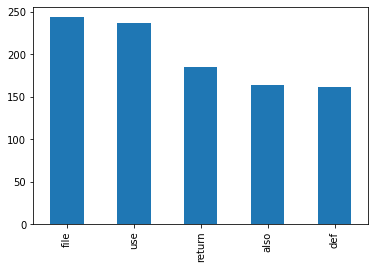

In [117]:
word_counts.python.sort_values(ascending = False).head().plot(kind = 'bar')

<AxesSubplot:>

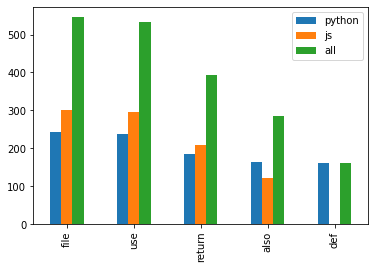

In [119]:
word_counts.sort_values(by = 'python', ascending = False).head().plot(kind = 'bar')

Exploring the target

barplots

evaluation - hypothesis testing


In [ ]:
# Are there unique words that identify a Javascript or Python readme?

uniques_labels = pd.concat